# Fake or Real News

**Our goal is to build a model to spot real and fake news based on the news content.**

[details](https://www.kaggle.com/rchitic17/real-or-fake#fake_or_real_news.csv)

## Importing modules and data

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from torchtext.data import Field
from torchtext.data import TabularDataset
from torchtext.vocab import GloVe
from torchtext.data import Iterator, BucketIterator

In [0]:
USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")

In [4]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Exploring the data

In [0]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/fake_or_real_news.csv')

In [116]:
df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
Unnamed: 0    6335 non-null int64
title         6335 non-null object
text          6335 non-null object
label         6335 non-null object
dtypes: int64(1), object(3)
memory usage: 198.0+ KB


In [118]:
df.isna().sum()

Unnamed: 0    0
title         0
text          0
label         0
dtype: int64

In [119]:
df.label.unique()

array(['FAKE', 'REAL'], dtype=object)

In [120]:
print('Numbers of fake news: ', (df.label == 'FAKE').sum())
print('Numbers of real news: ', (df.label == 'REAL').sum())

Numbers of fake news:  3164
Numbers of real news:  3171


In [0]:
df['numbers_of_word'] = df.text.apply(str.split).apply(len)

In [122]:
df.numbers_of_word.describe()

count     6335.000000
mean       776.300710
std        854.333358
min          0.000000
25%        289.000000
50%        597.000000
75%       1024.000000
max      20891.000000
Name: numbers_of_word, dtype: float64

## Data preparation

We are going to prepare the data to feed our model using torchtext.

In [0]:
tokenize = lambda x: x.split()
TEXT = Field(sequential=True, tokenize=tokenize, lower=True)
LABEL = Field(sequential=False, use_vocab=True)

In [0]:
csv_datafields = [("Unnamed: 0", None),
                 ("title", TEXT),
                 ("text", TEXT),
                 ("label", LABEL)
                 ]
trainData = TabularDataset(path="/content/drive/My Drive/Colab Notebooks/fake_or_real_news.csv",
                           format='csv',
                           skip_header=True,
                           fields=csv_datafields,         
                           )
trainData, valData, testData = trainData.split(split_ratio=[0.7, 0.2, 0.1])

In [8]:
# build the vocabulary
vectors = GloVe(name='6B', dim=300)
TEXT.build_vocab(trainData, vectors=GloVe(name='6B', dim=300))
LABEL.build_vocab(trainData)

.vector_cache/glove.6B.zip: 862MB [00:47, 18.0MB/s]                           
100%|█████████▉| 399200/400000 [00:39<00:00, 10042.21it/s]

In [0]:
 train_loader, val_loader = BucketIterator.splits(
                              (trainData, valData),
                               batch_size=64,
                               device=device,
                               sort_key=lambda x: len(x.text), # the function used to group the data.
                               sort_within_batch=False,
                               repeat=False,
                            )
test_loader = Iterator(testData, batch_size=64, device=device, sort=False, sort_within_batch=False, repeat=False)


## Building model

We are going to build a bidirectional LSTM model with attention mechanism.

In [0]:
weight_matrix = TEXT.vocab.vectors
class LSTMwAttn(nn.Module):
    def __init__(self, 
                 vocab_num, 
                 hidden_size, 
                 output_size, 
                 num_layers=1, 
                 dropout=0.2,
                 bidirectional=True,
                 embed_size=weight_matrix.size(1),
                 attention=True):
        super(LSTMwAttn, self).__init__()
        
        self.vocab_num = vocab_num
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1
        self.num_directions = num_directions
        self.attention = attention
        
        self.embedding = nn.Embedding(vocab_num, embed_size)
        self.embedding.weight = nn.Parameter(weight_matrix.clone().detach(), requires_grad=True)

        self.rnn = nn.LSTM(embed_size, 
                           hidden_size, 
                           num_layers, 
                           dropout=0 if num_layers == 1 else dropout, 
                           bidirectional=bidirectional)
      
        self.attn = nn.Linear(hidden_size*num_layers*num_directions, 1)
        self.decoder = nn.Linear(hidden_size*num_layers*num_directions, output_size)
        
    def forward(self, x, hidden=None):
        # shape of x: seq_num x batch_size
        embedded = self.embedding(x)
        # shape of embedded : seq_num x batch_size x embed_size
        rnn_outputs, (hidden, cell) = self.rnn(embedded, hidden)
        # shape of rnn_outputs: seq_num x batch_size x (hidden_size x num_layers x num_directions)
        # shape of hidden: (num_layers x num_directions) x batch_size x hidden_size
        # shape of cell: (num_layers x num_directions) x batch_size x hidden_size
        if self.attention:
            attn_weights = F.softmax(torch.sigmoid(self.attn(rnn_outputs)), dim=0)
            # shape of attn_weights: seq_num x batch_size x 1
            attn_applied = attn_weights * rnn_outputs
            # shape of attn_applied: seq_num x batch_size x (hidden_size x num_layers x num_directions)
            weighted_sum = attn_applied.sum(0)
            # shape of weighted_sum: batch_size x (hidden_size x num_layers x num_directions)
            outputs = self.decoder(weighted_sum)
            # shape of outputs: batch_size x output_size
        else:
            outputs = self.decoder(hidden.reshape(hidden.size(1), -1))
            # shape of outputs: batch_size x output_size
        return outputs
      
    def initHidden(self, batch_size):
        return (torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=device),
                torch.zeros(self.num_layers * self.num_directions, batch_size, self.hidden_size, device=device))

In [175]:
LSTM_HIDDEN_SIZE = 5
OUTPUR_SIZE = len(set(trainData.label))
model = LSTMwAttn(len(TEXT.vocab), LSTM_HIDDEN_SIZE, OUTPUR_SIZE).to(device)
model

LSTMwAttn(
  (embedding): Embedding(160263, 300)
  (rnn): LSTM(300, 5, bidirectional=True)
  (attn): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Linear(in_features=10, out_features=2, bias=True)
)

## Model training

### Optimizer and loss function

In [0]:
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
criterion = F.cross_entropy

### Training and testing function

In [0]:
def trainModel(data_loader, criterion, optimizer, train_losses=[], train_accuracies = []):
    model.train()
    losses = []
    accuracies = []
    for bach_idx, sample in enumerate(data_loader):
        optimizer.zero_grad()
        prediction = model(sample.text)
        target = sample.label - 1
        loss = criterion(prediction, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        pred_class = torch.argmax(prediction, dim=1)
        accuracy = ((pred_class - target) == 0).sum().item() / target.size(0)
        accuracies.append(accuracy)
    train_losses.append(np.mean(losses))
    train_accuracies.append(np.mean(accuracies))
    print('\nEpoch: {}/{}\nTraining Loss: {:.4f}\tTraining Categorical Accuracy: {:.4f}\t'
          .format(epoch+1, NUM_EPOCHS, train_losses[-1], train_accuracies[-1]))
    return train_losses, train_accuracies
  
def testModel(data_loader, criterion, val, val_losses=[], val_accuracies=[]):
    model.eval()
    losses = []
    accuracies = []
    for sample in data_loader:
        with torch.no_grad(): prediction = model(sample.text)
        target = sample.label - 1
        loss = criterion(prediction, target)
        losses.append(loss.item())
        pred_class = torch.argmax(prediction, dim=1)
        accuracy = ((pred_class - target) == 0).sum().item() / target.size(0)
        accuracies.append(accuracy)
    if val:
        val_losses.append(np.mean(losses))
        val_accuracies.append(np.mean(accuracies))
        print('Validation Loss: {:.4f}\tValidation Categorical Accuracy: {:.4f}'
              .format(val_losses[-1], val_accuracies[-1]))
        return val_losses[-1], val_accuracies[-1], val_losses, val_accuracies
    return np.mean(losses), np.mean(accuracies)

In [0]:
def saveModel(maxAcc, val_acc, val_loss):
    if val_acc > maxAcc:
        torch.save({
            'model_state_dict': model.state_dict(),
            'loss': val_loss,
            'accuracy': val_acc,
            }, PATH)
        print('Validation accuracy increased from {:5f} to {:5f}, saving model to {}'.format(maxAcc, val_acc, PATH))
        return val_acc
    return maxAcc

### Training loop

In [179]:
%%time
NUM_EPOCHS = 20
maxAcc = 0
PATH = './attnLSTM_best.pth'
print('Train on {} samples, validate on {} samples'.format(len(train_loader.dataset), len(val_loader.dataset)))
train_losses,train_accuracies = [], []
val_losses, val_accuracies = [], []
for epoch in range(NUM_EPOCHS):
    train_losses, train_accuracies = trainModel(train_loader, criterion, optimizer, train_losses, train_accuracies)
    val_loss, val_acc, val_losses, val_accuracies = testModel(val_loader, criterion, True, val_losses, val_accuracies)
    maxAcc = saveModel(maxAcc, val_acc, val_loss)

Train on 4434 samples, validate on 634 samples

Epoch: 1/20
Training Loss: 0.6844	Training Categorical Accuracy: 0.5892	
Validation Loss: 0.7104	Validation Categorical Accuracy: 0.4759
Validation accuracy increased from 0.000000 to 0.475916, saving model to ./attnLSTM_best.pth

Epoch: 2/20
Training Loss: 0.6515	Training Categorical Accuracy: 0.6834	
Validation Loss: 0.5901	Validation Categorical Accuracy: 0.6435
Validation accuracy increased from 0.475916 to 0.643534, saving model to ./attnLSTM_best.pth

Epoch: 3/20
Training Loss: 0.5292	Training Categorical Accuracy: 0.8431	
Validation Loss: 0.3764	Validation Categorical Accuracy: 0.8695
Validation accuracy increased from 0.643534 to 0.869504, saving model to ./attnLSTM_best.pth

Epoch: 4/20
Training Loss: 0.3781	Training Categorical Accuracy: 0.8907	
Validation Loss: 0.2488	Validation Categorical Accuracy: 0.9226
Validation accuracy increased from 0.869504 to 0.922629, saving model to ./attnLSTM_best.pth

Epoch: 5/20
Training Loss: 0

## Model evaulation

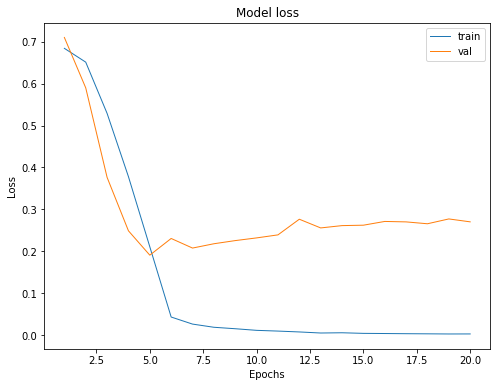

In [180]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_losses)+1), train_losses , label='train', linewidth=1)
plt.plot(range(1, len(val_losses)+1), val_losses, label='val', linewidth=1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model loss')
plt.show()


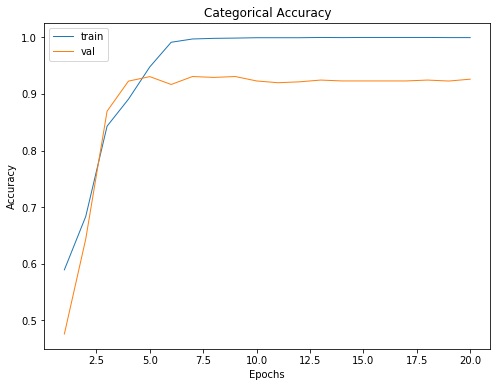

In [181]:
plt.figure(figsize=(8,6))
plt.plot(range(1, len(train_accuracies)+1), train_accuracies , label='train', linewidth=1)
plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='val', linewidth=1)
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Categorical Accuracy')
plt.show()



In [183]:
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
loss_best = checkpoint['loss']
accuracy_best = checkpoint['accuracy']
model.eval()

LSTMwAttn(
  (embedding): Embedding(160263, 300)
  (rnn): LSTM(300, 5, bidirectional=True)
  (attn): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Linear(in_features=10, out_features=2, bias=True)
)

In [184]:
test_loss, test_accuracy = testModel(test_loader, criterion, False)
print('Test Loss: {:.4f}\tTest Accuracy: {:.4f}'.format(test_loss, test_accuracy))

Test Loss: 0.2573	Test Accuracy: 0.9223
